# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [2]:
%run hw_framework.ipynb

c:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\magic.py:187: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  call = lambda f, *a, **k: f(*a, **k)


Wall time: 222 ms
Wall time: 18 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [50]:
def SGD(params, gradients, lr=1e-3): 
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [4]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [7]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n, 1), 2)))

best_possible_mse: 0.9741899395583768


### Модель

In [75]:
model = Sequential(
    Linear(10, 20),
    ReLU(),
    Dropout(),

    Linear(20, 10), 
    ReLU(),
    Dropout(),
    
    Linear(10, 1)
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [78]:
epochs = 100
batch_size = 10
learning_rate = 1e-1

2.0692119035307543


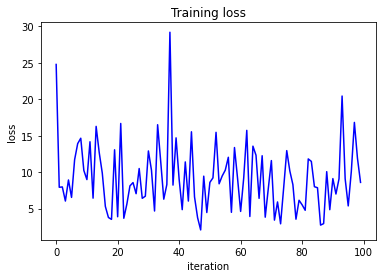

In [79]:
history = []
min_loss = 100

for i in range(epochs):
    avg_loss = 0
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        #print(loss)
        avg_loss += loss / len(x)
    
    min_loss = min(loss, min_loss)
        
    history.append(loss)

print(min_loss)
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

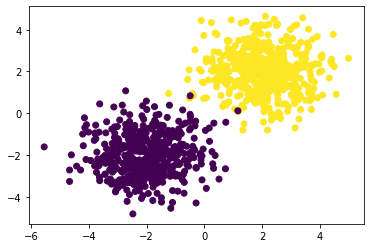

In [16]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [18]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [19]:
epochs = 20
batch_size = 2
learning_rate = 1e-2

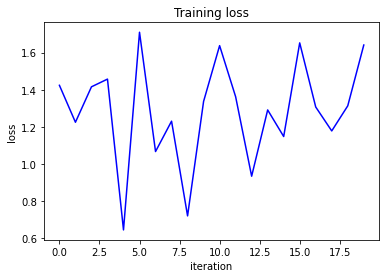

In [28]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
    history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [5]:
import os
from sklearn.datasets import fetch_openml
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [6]:
def one_hot_encoding(vec):
    return np.eye(10)[vec.astype(int)].astype(int)

In [7]:
y = one_hot_encoding(y)

Разделите датасет на train и validation.

In [8]:
def train_test_split(X, y, train_size=0.8):    
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)

    partition = int(n * train_size)

    X_train = X[indices[:partition]]
    y_train = y[indices[:partition]]
    
    X_test = X[indices[partition:]]
    y_test = y[indices[partition:]]

    return X_train, y_train, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val = train_test_split(X, y)

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [10]:
def accuracy(outputs, labels, batch_size):
    correct = (outputs.argmax(axis=1) == labels.argmax(axis=1)).sum()
    accuracy = 100.0 * correct / batch_size

    return accuracy

In [11]:
class History():
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def update(self, train_loss, val_loss, train_acc, val_acc):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)
        
    def show(self, title='Training history'):
        fig = plt.figure(figsize=(20, 8))
        fig.suptitle(title, fontsize=16)

        plt.subplot(1, 2, 1)
        plt.title('Loss')
        plt.plot(self.train_loss, 'o-', color='g', linewidth=2, markersize=5, label='Train loss')
        plt.plot(self.val_loss, 'o-', color='b', linewidth=2, markersize=5, label='Validation loss')
        plt.legend(loc='best')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.title('Accuracy')
        plt.plot(self.train_acc, 'o-', color='c', linewidth=2, markersize=5, label='Train accuracy')
        plt.plot(self.val_acc, 'o-', color='m', linewidth=2, markersize=5, label='Validation accuracy')
        plt.legend(loc='best')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.grid(True)

        plt.show()

In [79]:
def train(model, criterion, num_epochs, X_train, y_train, X_val, y_val, learning_rate):
    history = History()

    for epoch in range(num_epochs):
        avg_tr_loss = avg_val_loss = 0
        avg_tr_acc = avg_val_acc = 0

        model.train()
        for inputs, labels in loader(X_train, y_train, batch_size):
            outputs = model.forward(inputs)
            loss = criterion.forward(outputs, labels)

            grad = criterion.backward(outputs, labels)

            model.backward(inputs, grad)
            
            SGD(model.parameters(),
                model.grad_parameters(),
                learning_rate)

            avg_tr_loss += loss / len(X_train)
            avg_tr_acc += accuracy(outputs, labels, batch_size) / (len(X_train) / batch_size)
        
        if (epoch + 1) % 10 == 0:
            learning_rate *= 0.8

        model.eval()
        for inputs, labels in loader(X_val, y_val, batch_size):
            outputs = model.forward(inputs)
            loss = criterion.forward(outputs, labels)

            avg_val_loss += loss / len(X_val)
            avg_val_acc += accuracy(outputs, labels, batch_size) / (len(X_val) / batch_size)

        history.update(avg_tr_loss, avg_val_loss, avg_tr_acc, avg_val_acc)

        # show intermediate results
        print('Epoch:  %d/%d | Train loss: %.4f | Train accuracy: %.2f | Val loss: %.4f | Val Accuracy: %.2f' 
                %(epoch + 1, num_epochs, avg_tr_loss, avg_tr_acc, avg_val_loss, avg_val_acc))

    return history

In [87]:
%run hw_framework.ipynb

Wall time: 238 ms
Wall time: 10 ms


In [82]:
num_epochs = 60
batch_size = 16
learning_rate = 1e-2

model = Sequential(
    Linear(28 * 28, 128),
    BatchNorm(),
    Dropout(0.2),
    LeakyReLU(),

    Linear(128, 64),
    BatchNorm(),
    #Dropout(0.2),
    LeakyReLU(),

    Linear(64, 32),
    #BatchNorm(),
    #Dropout(0.2),
    LeakyReLU(),

    Linear(32, 10),
    SoftMax(),
)

criterion = CrossEntropy()

history = train(model, criterion, num_epochs, X_train, y_train, X_val, y_val, learning_rate)

Epoch:  1/60 | Train loss: 0.0647 | Train accuracy: 67.39 | Val loss: 0.0199 | Val Accuracy: 93.46
Epoch:  2/60 | Train loss: 0.0502 | Train accuracy: 74.96 | Val loss: 0.0143 | Val Accuracy: 94.91
Epoch:  3/60 | Train loss: 0.0463 | Train accuracy: 77.20 | Val loss: 0.0159 | Val Accuracy: 95.34
Epoch:  4/60 | Train loss: 0.0439 | Train accuracy: 77.68 | Val loss: 0.0109 | Val Accuracy: 96.11
Epoch:  5/60 | Train loss: 0.0426 | Train accuracy: 77.54 | Val loss: 0.0116 | Val Accuracy: 96.40
Epoch:  6/60 | Train loss: 0.0415 | Train accuracy: 78.09 | Val loss: 0.0117 | Val Accuracy: 96.71
Epoch:  7/60 | Train loss: 0.0393 | Train accuracy: 79.21 | Val loss: 0.0107 | Val Accuracy: 96.52
Epoch:  8/60 | Train loss: 0.0380 | Train accuracy: 79.78 | Val loss: 0.0114 | Val Accuracy: 96.86
Epoch:  9/60 | Train loss: 0.0388 | Train accuracy: 79.30 | Val loss: 0.0086 | Val Accuracy: 97.26
Epoch:  10/60 | Train loss: 0.0392 | Train accuracy: 79.13 | Val loss: 0.0088 | Val Accuracy: 97.36
Epoch:  1

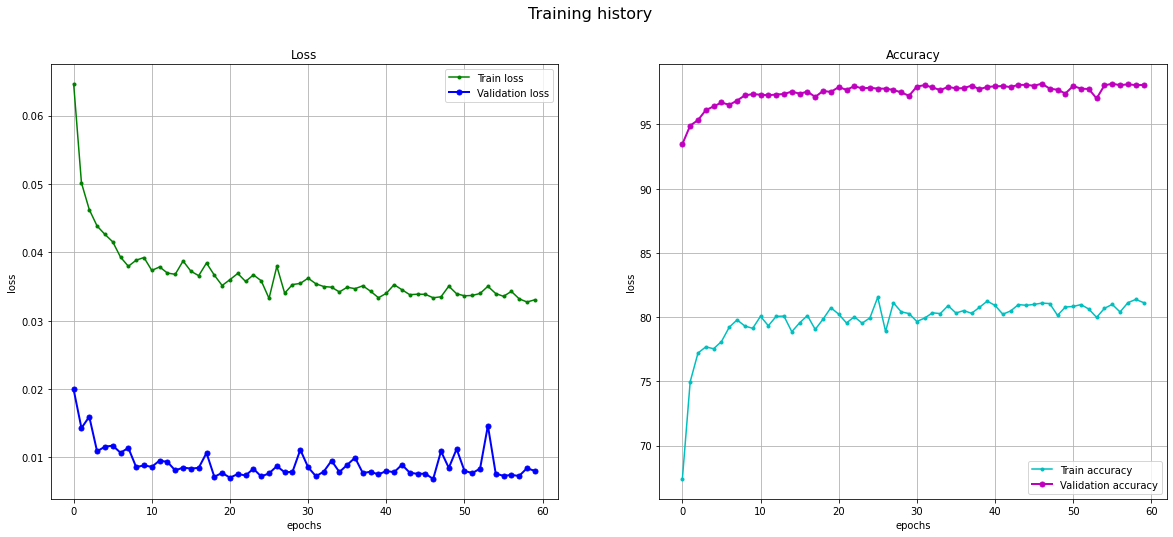

In [85]:
history.show()